In [45]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import random
import matplotlib.pyplot as plt
import collections
from scipy.optimize import fsolve

In [3]:
r = 0.0425
coupon = 0.0053
b = r - coupon
days = 49
t = days / 365
s = 151.03
underlyings = [i for i in range(130, 170)]
x = 0
put = 0
call = 0

In [30]:
def call_put(s, x, b, r, sig, t):
    d1 = (np.log(s/x) + t*(sig**2/2 + b))/(sig*(t**0.5))
    d2 = d1 - sig * (t**0.5)
    call = s*np.e**((b-r)*t)*norm.cdf(d1) - x*np.e**(-r*t)*norm.cdf(d2)
    put = x*np.e**(-r*t)*norm.cdf(-d2) - s*np.e**((b-r)*t)*norm.cdf(-d1)
    return call, put

def funcput(sig):
    return x*np.e**(-r*t)*norm.cdf(-((np.log(s/x) + t*(sig**2/2 + b))/(sig*(t**0.5)) - sig * (t**0.5))) - s*np.e**((b-r)*t)*norm.cdf(-(np.log(s/x) + t*(sig**2/2 + b))/(sig*(t**0.5))) - put

def funcall(sig):
    return s*np.e**((b-r)*t)*norm.cdf((np.log(s/x) + t*(sig**2/2 + b))/(sig*(t**0.5))) - x*np.e**(-r*t)*norm.cdf((np.log(s/x) + t*(sig**2/2 + b))/(sig*(t**0.5)) - sig * (t**0.5)) - call

def identify(ty, pos, opt, strike, val, l):
    global x, put, call
    rtn = [0] * l
    if ty == "Stock":
        for i in range(l):
            rtn[i] = pos * (underlyings[i] - val)
    elif opt == "Call":
        x = strike
        call = val
        sig = fsolve(funcall, 0.8)[0]
        for i in range(l):
            rtn[i] = pos * (call_put(underlyings[i], x, b ,r,sig, t)[0] - val)
    else:
        x = strike
        put = val
        sig = fsolve(funcall, 0.8)[0]
        for i in range(l):
            rtn[i] = pos * (call_put(underlyings[i], x, b ,r,sig, t)[1] - val)
    return rtn

In [31]:
ps = np.array(pd.read_csv("problem3.csv"))
dic = collections.defaultdict()
for line in ps:
    name = line[0]
    if name not in dic:
        dic[name] = [0] * len(underlyings)
    temp = identify(line[1], line[3], line[4], line[6], line[7], len(underlyings))
    for i in range(len(underlyings)):
        dic[name][i] += temp[i]


/Users/fend/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


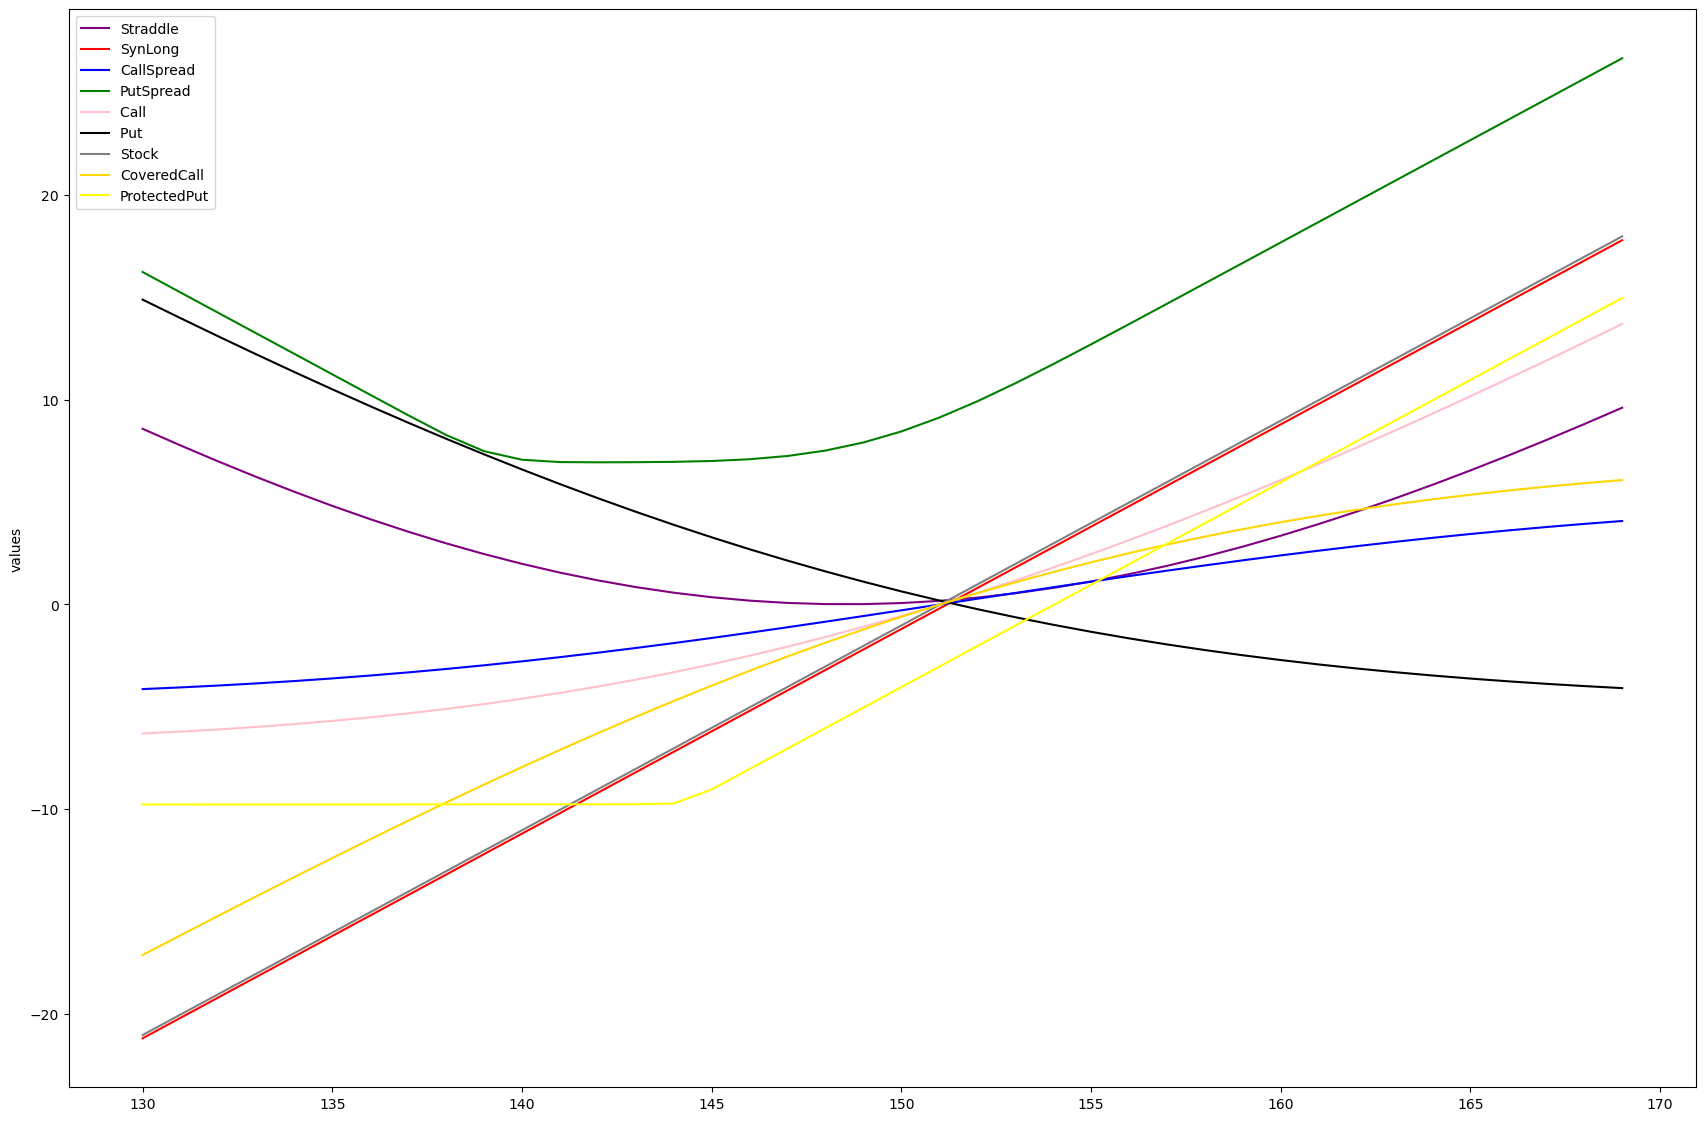

In [6]:

plt.figure(figsize=(21, 14))
plt.plot(underlyings, dic['Straddle'], linestyle='-',color='purple',label='Straddle')
plt.plot(underlyings, dic['SynLong'], linestyle='-',color='red',label='SynLong')
plt.plot(underlyings, dic['CallSpread'], linestyle='-',color='blue',label='CallSpread')
plt.plot(underlyings, dic['PutSpread'], linestyle='-',color='green',label='PutSpread')
plt.plot(underlyings, dic['Call '], linestyle='-',color='pink',label='Call ')
plt.plot(underlyings, dic['Put '], linestyle='-',color='black',label='Put ')
plt.plot(underlyings, dic['Stock'], linestyle='-',color='gray',label='Stock')
plt.plot(underlyings, dic['CoveredCall'], linestyle='-',color='gold',label='CoveredCall')
plt.plot(underlyings, dic['ProtectedPut'], linestyle='-',color='yellow',label='ProtectedPut')
plt.ylabel('prices')
plt.ylabel('values')
plt.legend()
plt.show()

In [34]:
df=pd.read_csv('DailyPrices.csv') 
std = df['AAPL'].std()
N=10000
simed_return = norm.rvs(0,std,N)
simed_price=151.03 * (100+simed_return)/100
ttm =39/365 


[175.1475255  167.97391398 158.08981324 ... 155.67486988 165.76107976
 158.6645392 ]


In [37]:
def sim_identify(ty, pos, opt, strike, val, l):
    global x, put, call
    rtn = [0] * l
    if ty == "Stock":
        for i in range(l):
            rtn[i] = pos * (simed_price[i] - val)
    elif opt == "Call":
        x = strike
        call = val
        sig = fsolve(funcall, 0.8)[0]
        for i in range(l):
            rtn[i] = pos * (call_put(simed_price[i], x, b ,r,sig, t)[0] - val)
    else:
        x = strike
        put = val
        sig = fsolve(funcall, 0.8)[0]
        for i in range(l):
            rtn[i] = pos * (call_put(simed_price[i], x, b ,r,sig, t)[1] - val)
    return rtn

In [39]:
dic = collections.defaultdict()
for line in ps:
    name = line[0]
    if name not in dic:
        dic[name] = [0] * len(simed_price)
    temp = sim_identify(line[1], line[3], line[4], line[6], line[7], len(simed_price))
    for i in range(len(simed_price)):
        dic[name][i] += temp[i]

/Users/fend/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [58]:
def calc(x):

    mu = np.mean(x)
    sd = np.std(x)
    VaR_Normal = -norm.ppf(0.05, mu, sd)
    ES_Normal = -mu + sd * norm.pdf(norm.ppf(0.05, 0, 1)) / 0.05

    return mu,VaR_Normal,ES_Normal


In [63]:
print('Straddle',calc(dic['Straddle']))
print('SynLong',calc(dic['SynLong']))
print('CallSpread',calc(dic['CallSpread']))
print('PutSpread',calc(dic['PutSpread']))
print('Call ',calc(dic['Call ']))
print('Put ',calc(dic['Put ']))
print('Stock',calc(dic['Stock']))
print('CoveredCall',calc(dic['CoveredCall']))
print('ProtectedPut',calc(dic['ProtectedPut']))

Straddle (7.410185932549264, 6.656724763474972, 10.230287590027842)
SynLong (-0.29012820997584565, 31.171506736113198, 39.01662274761265)
CallSpread (0.07944240181435154, 5.358651597574774, 6.7401468656871755)
PutSpread (18.4626678163342, 0.17426292084389416, 4.9087952088923)
Call  (3.5600288612867104, 14.29223597096361, 18.827431462916067)
Put  (3.8501570712625552, 12.183102062845133, 16.256196722238275)
Stock (-0.11617529764306991, 31.019533954697636, 38.87023380620758)
CoveredCall (-3.822808939620148, 22.32990095706245, 27.03144897213711)
ProtectedPut (1.5269432249229706, 20.088922685552337, 25.580224688575512)
